In [1]:
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
import datetime
from pathlib import Path
import supy as sp
import os

/Users/hamidrezaomidvar/anaconda3/envs/hamid_1/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  RuntimeWarning,


In [407]:
df = pd.read_csv('Crop/statistics_Lai_500m_landcovermask.csv')
df = df.filter(['MODIS_Date_AYYYYDDD', 'mean'])

/Users/hamidrezaomidvar/anaconda3/envs/hamid_1/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/hamidrezaomidvar/anaconda3/envs/hamid_1/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


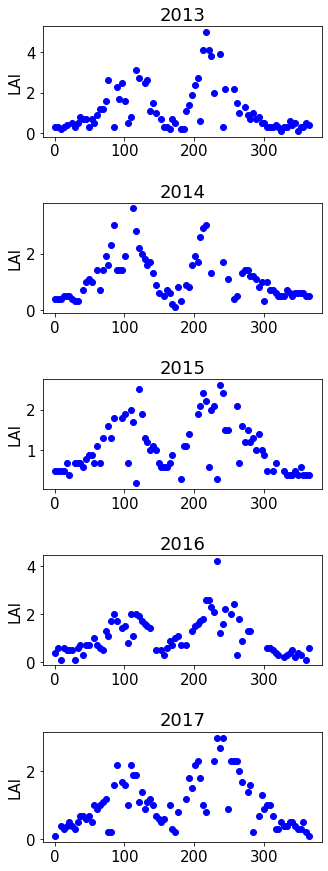

In [408]:
years=[2013,2014,2015,2016,2017]
fig,axs=plt.subplots(len(years),1,figsize=(5,15))
plt.subplots_adjust(hspace=.6)
counter=-1
for year in years:
    counter+=1
    ax=axs[counter]
    df_period = df[[i.startswith('A' + str(year)) for i in df['MODIS_Date_AYYYYDDD']]]
    df_period.loc[:, 'DOY'] = [
        int(i.split('A' + str(year))[1]) for i in df_period['MODIS_Date_AYYYYDDD']
    ]
    df_period = df_period.set_index('DOY')
    ax.scatter(df_period.index,df_period['mean'],color='b',marker='o')
    ax.set_title(year)
    ax.set_ylabel('LAI')
    
plt.savefig('Crop_LAI.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

In [2]:
df_AW=pd.read_excel('Crop/AWS/AWS2014_2017.xlsx')

In [4]:
df_AW_1=df_AW.drop(df_AW.index[[1,2]])
df_AW_1.columns=df_AW_1.iloc[0]
df_AW_final=df_AW_1.drop(df_AW_1.index[0])
x=[df_AW_final.iloc[0].TIMESTAMP+(x)*datetime.timedelta(minutes=30) 
   for x in range(len(df_AW_final))]
df_AW_final.insert(loc=0, column='New_T', value=x)

In [5]:
df_AW_final.columns

Index(['New_T', 'TIMESTAMP', 'RECORD', 'temp_air_10m_Avg', 'temp_air_8m_Avg',
       'temp_air_5m_Avg', 'temp_air_3m_Avg', 'rh_air_10m_Avg', 'rh_air_8m_Avg',
       'rh_air_5m_Avg', 'rh_air_3m_Avg', 'temp_soil_5cm_Avg',
       'temp_soil_10cm_Avg', 'temp_soil_20cm_Avg', 'temp_soil_40cm_Avg',
       'rh_soil_5cm_Avg', 'rh_soil_10m_Avg', 'rh_soil_20m_Avg',
       'rh_soil_40m_Avg', 'flx_soil_5cm_Avg', 'flx_soil_10cm_Avg',
       'flx_soil_20cm_Avg', 'flx_soil_40cm_Avg', '"shf_cal(1)"',
       '"shf_cal(2)"', '"shf_cal(3)"', '"shf_cal(4)"', 'gr_W_Avg', 'rr_W_Avg',
       'ar_W_Avg', 'tr_W_Avg', 'nr_W_Avg', 'pr_umol_Avg', 'gr_Mj_Tot',
       'rr_Mj_Tot', 'ar_Mj_Tot', 'tr_Mj_Tot', 'nr_Mj_Tot', 'pr_m_Tot',
       'ws_10m_Avg', 'ws_8m_Avg', 'ws_5m_Avg', 'ws_3m_Avg', 'wnd_dir',
       'Rain_Tot', 'B_Prs_Avg'],
      dtype='object', name=0)

In [6]:
df=df_AW_final.filter(['New_T',
                    'temp_air_10m_Avg',
                    'rh_air_10m_Avg',
                    'gr_W_Avg',
                    'rr_W_Avg',
                    'ar_W_Avg',
                    'tr_W_Avg',
                    'ws_10m_Avg',
                    'Rain_Tot',
                    'B_Prs_Avg',
                   ])
df.columns=['time','TA','RH','SWIN','SWOUT','LWIN','LWOUT','WS','P','PA']
df.index=df.time
df.drop('time',axis=1,inplace=True)
df=df.astype(float)

In [7]:
counter=0
years=[2015,2016,2017]
for year in years:
    counter+=1
    df_EC=pd.read_excel('Crop/EC/'+str(year-1)+'0601_'+str(year)+'0531.xlsx')
    df_EC_1=df_EC.drop('file_info',axis=1)
    df_EC_2=df_EC_1.drop(df_EC_1.index[[1,2]])
    df_EC_2.columns=df_EC_2.iloc[0]
    df_EC_3=df_EC_2.drop(df_EC_2.index[0])
    df_EC_4=df_EC_3.filter(['date','time','H','LE'])
    df_EC_4.dropna(thresh=1,inplace=True)
    df_EC_4['time']=df_EC_4.apply(lambda x: datetime.datetime.combine(x['date'],x['time']),axis=1)
    df_EC_5=df_EC_4.drop('date',axis=1).set_index('time')
    if counter==1:
        df_EC_final=df_EC_5
    else:
        df_EC_final=pd.concat([df_EC_final,df_EC_5])

In [8]:
df_final=df.merge(df_EC_final, left_index=True, right_index=True, how='inner')

In [9]:
df_final=df_final.astype(float)
df_final

,TA,RH,SWIN,SWOUT,LWIN,LWOUT,WS,P,PA,H,LE
time,,,,,,,,,,,
2014-06-01 00:30:00,20.60,77.29,0.0,0.247,422.9,435.6,3.236,0.0,1007.8720,-14.680379,NaN
2014-06-01 01:00:00,20.48,77.90,0.0,0.198,423.6,435.2,3.528,0.0,1007.5890,-11.091416,NaN
2014-06-01 01:30:00,20.45,77.85,0.0,0.153,423.9,434.9,4.146,0.0,1007.1030,-14.698169,NaN
2014-06-01 02:00:00,20.39,78.78,0.0,0.163,423.6,434.7,4.485,0.0,1006.6860,-13.681627,NaN
2014-06-01 02:30:00,20.26,79.85,0.0,0.274,419.7,433.8,4.754,0.0,1006.1810,-14.907820,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-05-31 21:30:00,24.61,56.67,0.0,0.254,420.3,442.6,0.000,0.0,1000.1070,-8.910277,19.713895
2017-05-31 22:00:00,24.14,56.50,0.0,0.310,421.2,438.8,0.000,0.0,1000.0860,-13.109733,22.979492
2017-05-31 22:30:00,23.99,55.20,0.0,0.172,424.5,441.5,0.000,0.0,999.9956,-24.751919,17.259623


In [10]:
df_final.to_csv('Crop/all_date.csv')

In [452]:
df=df_final
year=2017
name='crop'

In [453]:
temp=df[df.LE<0]
df.loc[temp.index,'LE']=np.nan
df=df.resample('1h').mean()

period_start=str(year)+'-01-01'
period_end=str(year+1)+'-01-01'
df_period=df[(df.index>=period_start) & (df.index<period_end)]

/Users/hamidrezaomidvar/anaconda3/envs/hamid_1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


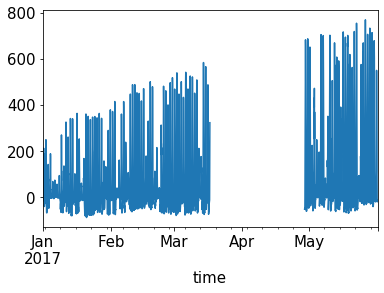

In [454]:
df_period['NETRAD']=(df_period['SWIN']-df_period['SWOUT'])+(df_period['LWIN']-df_period['LWOUT'])
df_period['NETRAD'].plot()

In [455]:
qs = df_period.apply (lambda row: row['NETRAD']-row['LE']-row['H'], axis=1)
df_period = df_period.assign(QS=qs.values)

Text(0, 0.5, 'W m$^{-2}$')

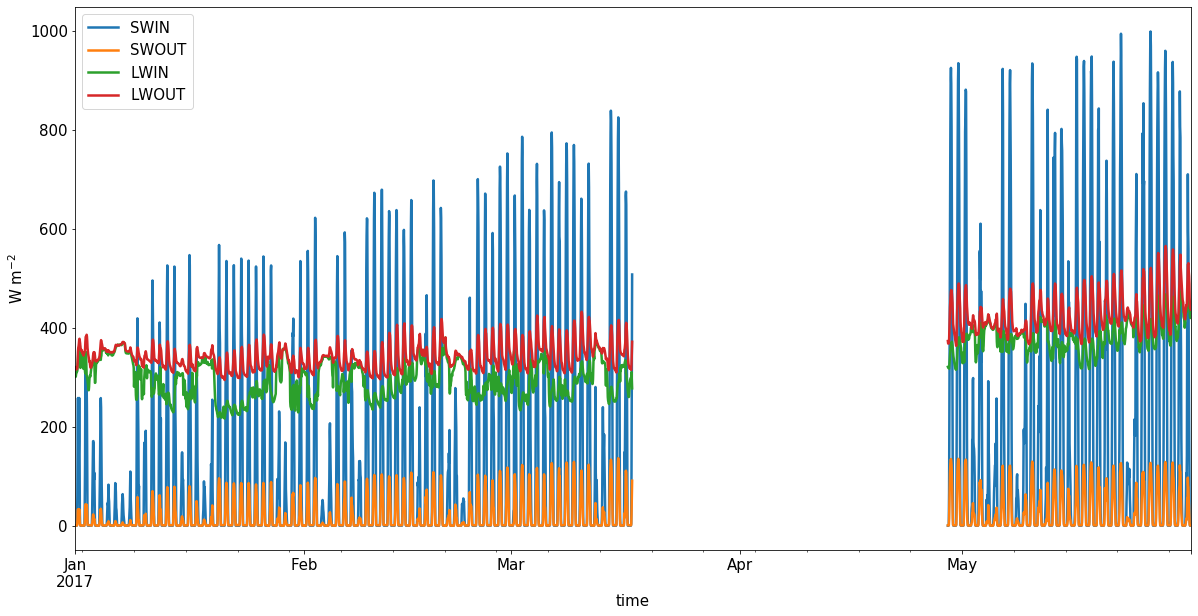

In [456]:
fig,ax=plt.subplots(1,1)
plt.rcParams.update({'font.size': 15})
df_period[['SWIN','SWOUT','LWIN','LWOUT']].plot(linewidth=2.5,figsize=(20,10),ax=ax)
ax.set_ylabel('W m$^{-2}$')

In [457]:
input_columns=['iy', 'id', 'it', 'imin', 'qn', 'qh', 'qe', 'qs', 'qf', 'U', 'RH', 'Tair', 'pres', 'rain', 
'kdown', 'snow', 'ldown', 'fcld', 'wuh', 'xsmd', 'lai', 'kdiff', 'kdir', 'wdir']
df_input=pd.DataFrame(columns=input_columns)
df_input.iy=df_period.index.year
df_input.id=[x.timetuple().tm_yday for x in df_period.index]
df_input.it=df_period.index.hour
df_input.imin=df_period.index.minute
df_input['kdown']=df_period.SWIN.values
df_input['ldown']=df_period.LWIN.values
df_input['U']=df_period.WS.values
df_input['snow']=0
df_input['rain']=0
df_input['rain']=df_period.P.values
df_input['RH']=df_period.RH.values
df_input['Tair']=df_period.TA.values
df_input['pres']=df_period.PA.values/10
df_input['qf']=0

In [458]:
for i in ['rain','U','RH','pres']:
    df_input.loc[df_input[df_input[i]<0].index,i]=-999
    
df_input.loc[df_input[df_input['Tair']<-50].index,'Tair']=-999
df_input.fillna(-999,inplace=True)
df_input.replace(-999,np.nan,inplace=True)
df_input.interpolate(limit_direction='both',inplace=True)
df_input.fillna(-999,inplace=True)

In [459]:
df_input.to_csv('Kc_2012_data_60.txt',sep=' ',index=0)
os.rename("./Kc_2012_data_60.txt", "runs/run/input/Kc_2012_data_60.txt")

In [460]:
path_runcontrol = Path('./runs/run/') / 'RunControl.nml'
df_state_init = sp.init_supy(path_runcontrol)
grid = df_state_init.index[0]
df_forcing = sp.load_forcing_grid(path_runcontrol, grid)

2019-11-06 16:00:19,590 — SuPy — INFO — All cache cleared.
2019-11-06 16:00:20,377 — SuPy — INFO — All cache cleared.


In [461]:
def modify_attr(df_state_init):
    df_state_init.loc[:,'emissionsmethod']=0
    df_state_init.loc[:,'sfr']=[0.0, #Paved
                            0.0, #Bldg
                            0.0, #EveTr
                            0.0, #DecTr
                            1.0, #Grass
                            0.0, #Bsoil
                            0.0] #Water
    df_state_init.loc[:,'lat']=32.76
    df_state_init.loc[:,'lng']=120.47
    return df_state_init
df_state_init=modify_attr(df_state_init)

In [462]:
df_state_init[['sfr','lat','lng']]

var      sfr                                  lat     lng
ind_dim (0,) (1,) (2,) (3,) (4,) (5,) (6,)      0       0
grid                                                     
98       0.0  0.0  0.0  0.0  1.0  0.0  0.0  32.76  120.47

In [463]:
error=1
for i in range(1):
    
    if (error <= 0.1):
        break
    df_output, df_state_final = sp.run_supy(df_forcing, df_state_init,save_state=False)
    final_state = df_state_final[df_state_init.columns.levels[0]].iloc[1]
    df_state_init.iloc[0] = final_state
    soilstore_before = df_state_final.soilstore_id.iloc[0]
    soilstore_after = df_state_final.soilstore_id.iloc[1]
    diff_soil = sum(abs(soilstore_after-soilstore_before))
    error = 100*diff_soil/soilstore_before.mean()
    print(error)


2019-11-06 16:00:21,448 — SuPy — INFO — ====================
2019-11-06 16:00:21,450 — SuPy — INFO — Simulation period:
2019-11-06 16:00:21,451 — SuPy — INFO —   Start: 2016-12-31 23:05:00
2019-11-06 16:00:21,453 — SuPy — INFO —   End: 2017-05-31 23:00:00
2019-11-06 16:00:21,454 — SuPy — INFO — 
2019-11-06 16:00:21,455 — SuPy — INFO — No. of grids: 1
2019-11-06 16:00:21,457 — SuPy — INFO — SuPy is running in serial mode
2019-11-06 16:00:29,944 — SuPy — INFO — Execution time: 8.5 s
2019-11-06 16:00:29,945 — SuPy — INFO — ====================

343.7194510036701


In [464]:
df_output_2=df_output.SUEWS.loc[grid].resample('1h').mean()
df_input.qe=df_period.LE.values
df_input.qh=df_period.H.values
df_input.qn=df_period.NETRAD.values
df_input.xsmd=df_output_2.iloc[1:,:].SMD.values
df_input.lai=df_output_2.iloc[1:,:].LAI.values
df_input.wdir=np.nan
df_input.fillna(-999,inplace=True)
df_input.to_csv('runs/data/'+name+'_'+str(int(df_input.iloc[0].iy))+'_data_60.txt',sep=' ',index=0)

In [465]:
# df_input_2017=df_input

In [470]:
# pd.concat([df_input_2014,df_input_2015,
#          df_input_2016,df_input_2017]).to_csv('runs/data/'+name+'_'+'all'+'_data_60.txt',sep=' ',index=0)